In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.17.2
pandas 0.25.1
sklearn 0.21.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, random_state = 11)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [5]:
# 函数式api 功能api
input = keras.layers.Input(shape = X_train.shape[1:])
hidden1 = keras.layers.Dense(30,activation='relu')(input)
hidden2 = keras.layers.Dense(30,activation='relu')(hidden1)
# 复合函数: f(x) = h(g(x))

concat = keras.layers.concatenate([input,hidden2])
output = keras.layers.Dense(1)(concat)

model = keras.models.Model(
    inputs=[input]
    ,outputs=[output]
)
model.summary()
model.compile(
    loss='mean_squared_error'
    ,optimizer=keras.optimizers.SGD(0.001)
)
call_backs=[
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)
]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_1[0][0]                

In [6]:
# 子类api实现
class WideAndDeepModel(keras.models.Model):
    def __init__(self):
        super(WideAndDeepModel,self).__init__()
        '''定义模型的层次'''
        self.hidden1_layer = keras.layers.Dense(30,activation='relu')
        self.hidden2_layer = keras.layers.Dense(30,activation='relu')
        self.output_layer = keras.layers.Dense(1) 
    
    def call(self,input):
        """完成模型的正向计算"""
        hidden1 = self.hidden1_layer(input)
        hidden2 = self.hidden2_layer(hidden1)
        concate = keras.layers.concatenate([input,hidden2])
        output = self.output_layer(concate)
        return output
model = keras.models.Sequential([WideAndDeepModel()])
model.build(input_shape=(None,8))

model.summary()
model.compile(
    loss=keras.metrics.mean_squared_error
    ,optimizer=keras.optimizers.SGD(0.001)
)

callbacks = [keras.callbacks.EarlyStopping(
    patience=5, min_delta=1e-2)]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
wide_and_deep_model (WideAnd multiple                  1239      
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


In [7]:
history=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50,callbacks=call_backs)

Train on 11610 samples, validate on 3870 samples
Epoch 1/50
11610/11610 [==============================] - 2s 192us/sample - loss: 1.8715 - val_loss: 0.8139
Epoch 2/50
11610/11610 [==============================] - 1s 101us/sample - loss: 0.6924 - val_loss: 0.7198
Epoch 3/50
11610/11610 [==============================] - 1s 100us/sample - loss: 0.6437 - val_loss: 0.6854
Epoch 4/50
11610/11610 [==============================] - 1s 99us/sample - loss: 0.6134 - val_loss: 0.6518
Epoch 5/50
11610/11610 [==============================] - 1s 103us/sample - loss: 0.5841 - val_loss: 0.6234
Epoch 6/50
11610/11610 [==============================] - 1s 112us/sample - loss: 0.5645 - val_loss: 0.5992
Epoch 7/50
11610/11610 [==============================] - 1s 104us/sample - loss: 0.5458 - val_loss: 0.5809
Epoch 8/50
11610/11610 [==============================] - 1s 105us/sample - loss: 0.5309 - val_loss: 0.5752
Epoch 9/50
11610/11610 [==============================] - 1s 100us/sample - loss: 0.5181

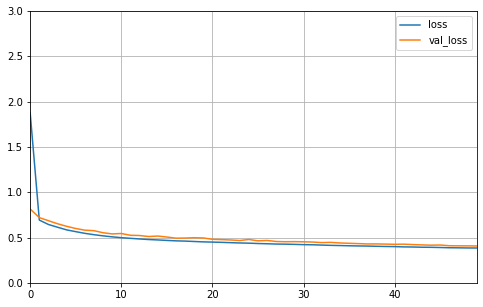

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 3)
    plt.show()
plot_learning_curves(history)